In [1]:
import pymc3 as pm
import graphviz
import arviz as az
az.style.use('seaborn')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/var/folders/kz/3m7b5b5n7n19qtpq86vft4ww0000gn/T/ipykernel_55110/979436451.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  az.style.use('seaborn')


### Generate data

In [2]:
num_samples = 5_000

# Generate random numbers from a uniform distribution over the interval [0, 1)
random_numbers = np.random.rand(num_samples)
default_rates = random_numbers*0.1


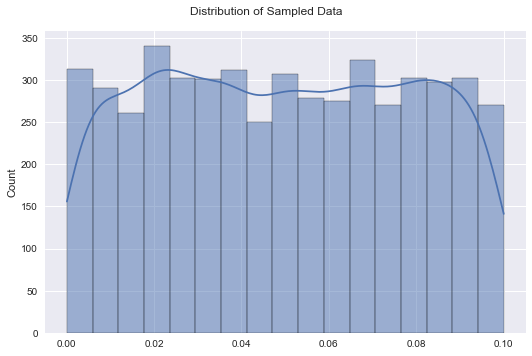

In [3]:
sample_distribution = sns.displot(
    data = default_rates,
    kde = True,
    aspect = 1.5
)

sample_distribution.fig.suptitle('Distribution of Sampled Data')

plt.tight_layout();

### Specify model and *"push inference button"*

In [4]:
# Prior parameters
n_SMEs = 1_000
prob = 0.03

In [5]:
# Model definition
with pm.Model() as default_rate_model:
    # Prior for the default rate
    default_rate = pm.Beta('default_rate', alpha = 1, beta = 1)
    
    # Likelihood of the observed data
    defaults = pm.Gamma('defaults', alpha=default_rate * n_SMEs, beta=n_SMEs, observed=default_rates)
    
    # MCMC sampling
    trace = pm.sample(5_000, tune=2_500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [default_rate]


/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.889607966232641, but sho

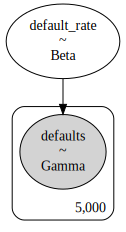

In [6]:
# plot causal relationships in model
pm.model_to_graphviz(default_rate_model)

### Check posterior predictive

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


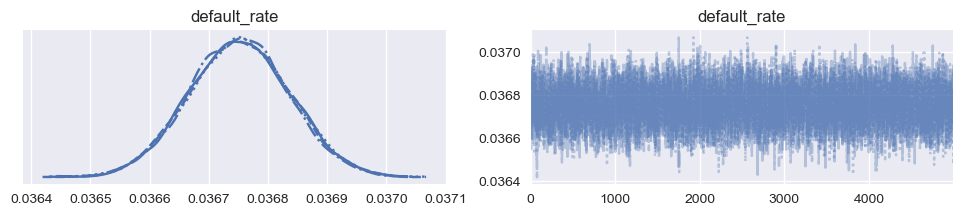

In [7]:
az.plot_trace(trace);

* stationarity (good! we need this for the `MCMC` simulation to converge...)
* note 4 chains (essentially all lying on top of each other, LHS-plot)

### Summarize posterior

In [8]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
default_rate,0.037,0.0,0.037,0.037,0.0,0.0,8492.0,14269.0,1.0


* see mean value for `default_rate` sampled from posterior distribution (3.7%)
* see value for `r_hat`: the closer it is to `1`, the more the model converges

Got error No model on context stack. trying to find log_likelihood in translation.


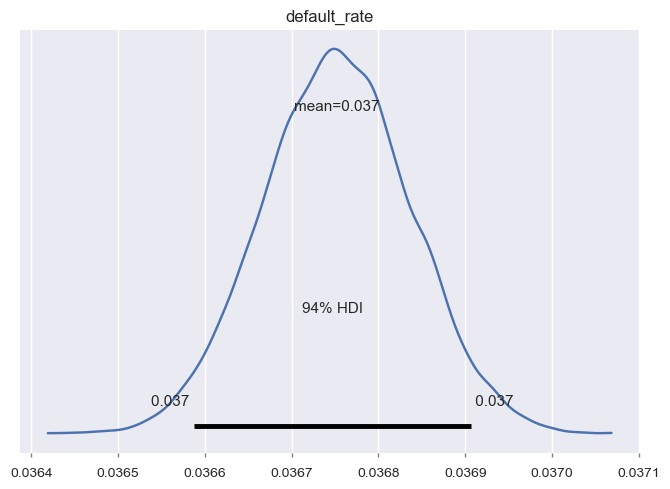

In [9]:
# Posterior analysis
az.plot_posterior(trace, var_names=['default_rate']);

* this is **bayesian**: we get a *distribution* for default rates (indicating our uncertainty around its mean value - as opposed to a (long-term) expected single value for it)

In [10]:
with default_rate_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    # Create an InferenceData object using the posterior predictive samples
    data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

Text(0.5, 1.0, 'Posterior Predictive Check')

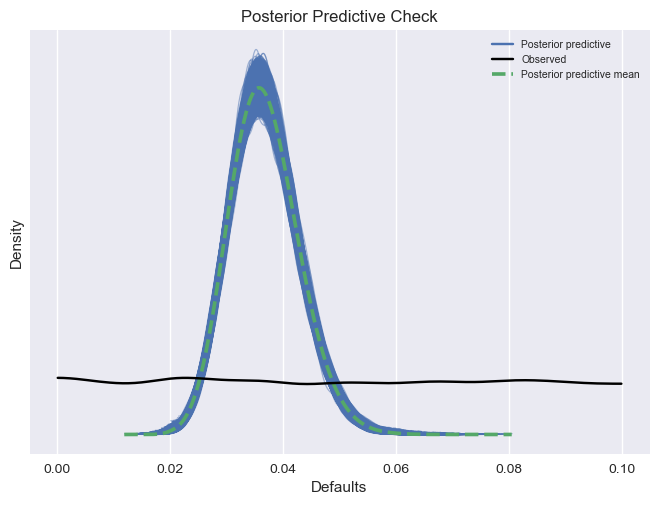

In [11]:
# Plotting posterior distribution vs real distribution using ArviZ
az.plot_ppc(data, var_names=['defaults'], alpha=0.5)

# Customize the plot
plt.xlabel('Defaults')
plt.ylabel('Density')
plt.title('Posterior Predictive Check')

### TODO
* use `lognormal` for `DGP`
* predict